# Exercise Set 12


## Mohaddeseh Mozaffari

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set()

In [2]:
data = np.loadtxt("fitinput.txt")

In [3]:
x = data[:,0]
y = data[:,1]

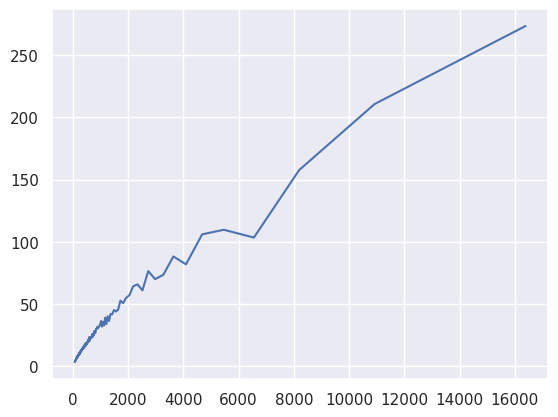

In [4]:
plt.plot(x,y)
plt.show()

# Q1:

In [5]:
def Y(x, a, H):
    """fitting function

    Args:
        x (1d_array): data
        a (float): free parameter
        H (float): free parameter

    Returns:
        1d_array: 
    """
    return a * np.power(x,H)

In [6]:
def chi2(yobs, yth, sigma=1):
    """chi square

    Args:
        yobs (1d_array): observed data
        yth (1d_array): theoritical data
        sigma (int, optional): variance of data. Defaults to 1.

    Returns:
        float: chi^2
    """
    return np.sum((yobs - yth)**2 / sigma)

In [7]:
def mcmc(N_iteration, stepsize, x , y, chi2, Y):
    """MCMC method

    Args:
        N_iteration (int): number of mcmc step
        stepsize (float): size of step for find new variable
        x (1d_array): x data
        y (1d_array): y data
        chi2 (func): function for calculate chi square
        Y (func): data-fitting function

    Returns:
        float, float, list:: a, h parameters for fitting function and chi2 of accepted parameter
    """
    CHI2 = []
    a0 = np.random.rand()
    H0 = np.random.rand()

    chi0 = chi2(yobs=y , yth=Y(x=x, a=a0, H=H0))

    for _ in range(N_iteration):
        a_next = a0 + np.random.uniform(-stepsize, stepsize)
        H_next = H0 + np.random.uniform(-stepsize, stepsize)
        chi_new = chi2(yobs=y , yth=Y(x=x, a=a_next, H=H_next))

        dx = chi_new - chi0
        ar = min(1, np.exp(-dx/2))

        if np.random.random() <= ar:
            a0 = a_next
            H0 = H_next
            CHI2.append(chi_new)
            chi0 = chi_new
        
    return  a0, H0 , CHI2


In [ ]:
a , H , Chi = mcmc(100000, 1, x, y, chi2, Y)

In [42]:
a

0.15605777963362644

In [43]:
H

0.7695090965115425

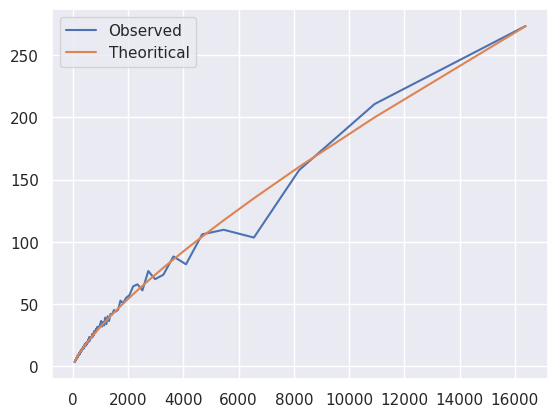

In [44]:
plt.plot(x, y, label="Observed")
plt.plot(x, Y(x, a, H), label="Theoritical")
plt.legend()
plt.show()

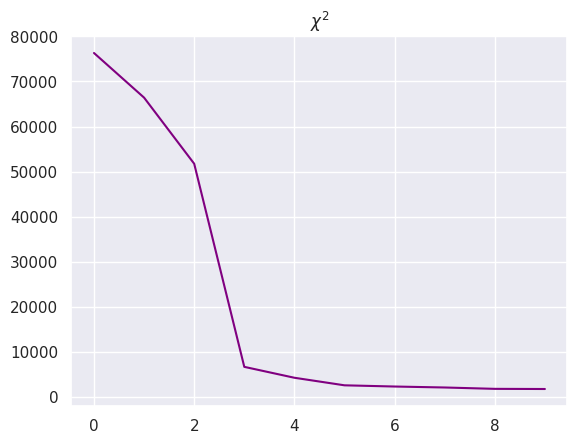

In [45]:
plt.plot(Chi, color="purple")
plt.title(r"$\chi^2$")
plt.show()

In [46]:
A = np.linspace(a-1 , a+1, 1000)
X = []
for aa in A:
    yth = Y(x, aa, H)
    X.append(chi2(y, yth))

In [47]:
X = np.array(X)

In [48]:
fig = px.line(x=A, y=np.exp(-X/(2* max(Chi))))
fig.add_hline(y=0.606)
fig.show()

In [56]:
print("a best:", round(a,3),"with eror:", round((0.231 - 0.076)/2, 3))

a best: 0.156 with eror: 0.078


In [50]:
h = np.linspace(H-1 , H+1, 1000)
X = []
for hh in h:
    yth = Y(x, a, hh)
    X.append(chi2(y, yth))

In [51]:
X = np.array(X)

In [52]:
fig = px.line(x=h, y=np.exp(-X/(2* max(Chi))))
fig.add_hline(y=0.606)
fig.show()

In [53]:
print("H best:", round(H,3),"with eror, sigma plus:", round(0.814 - H, 3), "and sigma minus:" , round(H - 0.686, 3))

H best: 0.77 with eror, sigma plus: 0.044 and sigma minus: 0.084


# Q2:

In [123]:
def hmc(N_mcmc, N_hmc, stepsize, epsilon, x , y, chi2, Y):
    """HMC method

    Args:
        N_mcmc (int): number of iteration of mcmc steps
        N_hmc (int): number of iteration of hmc steps
        stepsize (float): size of step for find new variable in mcmc loop
        epsilon (float): delta t
        x (1d_array): x data
        y (1d_array): y data
        chi2 (func): function for calculate chi square
        Y (func): data-fitting function

    Returns:
        float, float, list: a, h parameters for fitting function and chi2 of accepted parameter
    """

    CHI2 = []
    a0 = np.random.rand()
    H0 = np.random.rand()

    chi0 = chi2(yobs=y , yth=Y(x=x, a=a0, H=H0))

    for _ in range(N_mcmc):
        
        ksi0a = np.random.normal()
        ksi0H = np.random.normal()

        for j in range(N_hmc):
            dHda = - np.sum((y - Y(x=x, a=a0, H=H0)) * (x**(H0)))
            dHdH = - np.sum((y - Y(x=x, a=a0, H=H0)) * a0 * np.log(x) * (x**(H0)))

            a0_j =  a0 + ksi0a* epsilon + (0.5)* (epsilon**2) * (-dHda)
            h0_j =  H0 + ksi0H* epsilon + (0.5)* (epsilon**2) * (-dHdH)

            dHda_j = - np.sum((y - Y(x=x, a=a0_j, H=h0_j)) * (x**(h0_j)))
            dHdH_j = - np.sum((y - Y(x=x, a=a0_j, H=h0_j)) * a0_j * np.log(x) * (x**(h0_j)))

            ksi_ja = ksi0a + 0.5 * epsilon * (- dHda_j - dHda)
            ksi_jH = ksi0H + 0.5 * epsilon * (- dHdH_j - dHdH)
            
            a0 = a0_j
            H0 = h0_j
            ksi0a = ksi_ja
            ksi0H = ksi_jH

        a_next = a0 + np.random.uniform(-stepsize, stepsize)
        H_next = H0 + np.random.uniform(-stepsize, stepsize)

        chi_new = chi2(yobs=y , yth=Y(x=x, a=a_next, H=H_next))

        dx = chi_new - chi0
        ar = min(1, np.exp(-dx/2))

        if np.random.random() <= ar:
            a0 = a_next
            H0 = H_next
            chi0 = chi_new
            CHI2.append(chi0)
        
    return  a0, H0, CHI2


In [ ]:
a , H, Chi = hmc(1000, 5, 1, 0.0001 , x, y, chi2, Y)

In [250]:
a

0.15015381185943297

In [251]:
H

0.7723382195432875

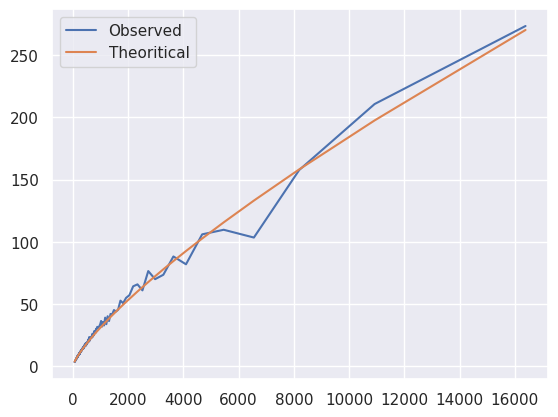

In [252]:
plt.plot(x, y, label="Observed")
plt.plot(x, Y(x, a, H), label="Theoritical")
plt.legend()
plt.show()

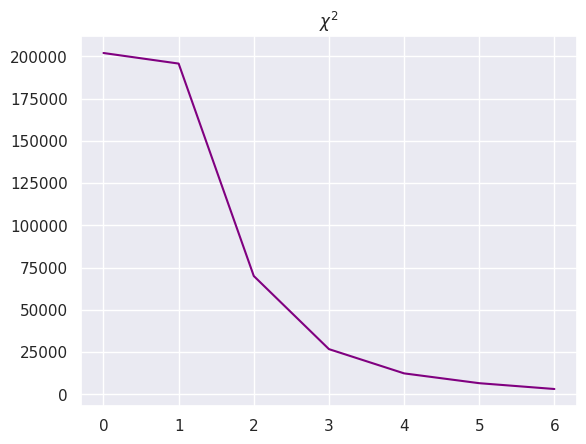

In [253]:
plt.plot(Chi, color="purple")
plt.title(r"$\chi^2$")
plt.show()

In [264]:
A = np.linspace(a-1 , a+1, 1000)
X = []
for aa in A:
    yth = Y(x, aa, H)
    X.append(chi2(y, yth))

In [265]:
X = np.array(X)

In [266]:
fig = px.line(x=A, y=np.exp(-X/(2* max(Chi))))
fig.add_hline(y=0.606)
fig.show()

In [262]:
print("a best:", round(a,3),"with eror:", round((0.273 - 0.027)/2, 3))

a best: 0.15 with eror: 0.123


In [258]:
h = np.linspace(H-1 , H+1, 1000)
X = []
for hh in h:
    yth = Y(x, a, hh)
    X.append(chi2(y, yth))

In [259]:
X = np.array(X)

In [260]:
fig = px.line(x=h, y=np.exp(-X/(2* max(Chi))))
fig.add_hline(y=0.606)
fig.show()

In [263]:
print("H best:", round(H,3),"with eror, sigma plus:", round(0.843 - H, 3), "and sigma minus:" , round(H - 0.563, 3))

H best: 0.772 with eror, sigma plus: 0.071 and sigma minus: 0.209
